### Final Report

Group 5:
- Zhengling Jiang, Jenny Lee, Shuhao Zhang, Lorraine Luo

# Project on Housing Market Trend Prediction in California

In [1]:
library(dplyr)
library(ggplot2)
library(GGally)
library(tidyverse)
library(caret)
library(glmnet)
library(car)
library(broom)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ lubridate 1.9.2     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.0
✔ readr     2.1.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift


Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘

## Introduction

California's housing market, known for its complexity and diversity, presents unique challenges for predictive modeling. This study aims to predict housing values in this market, focusing on factors like median age, rooms, bedrooms, population, households, median income, and ocean proximity. According to Federal Reserve Bank of Chicago (2018), neighborhoods, particularly emphasizing property characteristics and geographic variables may have a relationship with the housing value. This research provides valuable insights into how similar variables can influence housing prices, offering a pertinent context for our analysis in California. The impact of natural landscape features like ocean proximity on property values is also a popular topic in real estate market (Shi et al, 2022). Our study seeks to use the data set from Kaggle to examine the prediction question: **how well can the housing values be predicted using factors such as housing median age, total rooms, total bedrooms, population, households, median income, and ocean proximity? Among these, which variables serve as the most influential predictors for the median house value? And how accurately can we build a predictive model for housing values using these variables?**

The dataset is derived from the 1990 California census. The dataset provides detailed information about houses in various California districts, based on the 1990 census data. The dataset contains a total number of 10 variables and 20640 observations. In this study, we will focus on predictive, and we will use linear regression and LASSO models to do the prediction study.

Dataset Link: https://www.kaggle.com/datasets/camnugent/california-housing-prices

## Methods and Results

### Exploratory Data Analysis (EDA)

#### Load Data

In [3]:
urlfile="https://raw.githubusercontent.com/ageron/handson-ml/master/datasets/housing/housing.csv"

housing <- read.csv(urlfile)
head(housing)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,-122.23,37.88,41,880,129,322,126,8.3252,452600,NEAR BAY
2,-122.22,37.86,21,7099,1106,2401,1138,8.3014,358500,NEAR BAY
3,-122.24,37.85,52,1467,190,496,177,7.2574,352100,NEAR BAY
4,-122.25,37.85,52,1274,235,558,219,5.6431,341300,NEAR BAY
5,-122.25,37.85,52,1627,280,565,259,3.8462,342200,NEAR BAY
6,-122.25,37.85,52,919,213,413,193,4.0368,269700,NEAR BAY


**Explanatory Variables (Features):** <br>
1. longitude: A measure of how far west a house is; a higher value is farther west [**Numeric**]
2. latitude: A measure of how far north a house is; a higher value is farther north [**Numeric**]
3. housingMedianAge: Indicates the median age of houses within a block. [**Numeric**]
4. totalRooms: Aggregate number of rooms across all houses in a block.  [**Numeric**]
5. totalBedrooms: Aggregate number of bedrooms across all houses in a block. [**Numeric**]
6. population: Total number of people residing within a block [**Numeric**]
7. households: Number of individual households within a block. A household refers to a group of people living in a single home unit.  [**Numeric**]
8. medianIncome: Median income of households in a block, represented in tens of thousands of US Dollars.  [**Numeric**]
9. oceanProximity: Categorizes a block's proximity to the ocean. Possible values: 'NEAR BAY', '<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'ISLAND'. [**Categorical**]

**Response Variable (Target):** <br>
medianHouseValue: Median house value for households within a **block** (measured in US Dollars) [**Numeric**]

**Note:** All the data were collected at the block level. A "block" is a land area bounded by streets or other boundaries in a city. It contains multiple households. In this dataset, each observation aggregates data for all households within a single block. 

#### Clean and Wrangle Data

The original dataset included longitude and latitude values. However, we excluded them due to non-unique coordinates across blocks and the limited interpretability these values offer for housing price predictions. Instead, we prioritized features that more directly relate to housing characteristics and regional factors.

In [4]:
summary(housing)

   longitude         latitude     housing_median_age  total_rooms   
 Min.   :-124.3   Min.   :32.54   Min.   : 1.00      Min.   :    2  
 1st Qu.:-121.8   1st Qu.:33.93   1st Qu.:18.00      1st Qu.: 1448  
 Median :-118.5   Median :34.26   Median :29.00      Median : 2127  
 Mean   :-119.6   Mean   :35.63   Mean   :28.64      Mean   : 2636  
 3rd Qu.:-118.0   3rd Qu.:37.71   3rd Qu.:37.00      3rd Qu.: 3148  
 Max.   :-114.3   Max.   :41.95   Max.   :52.00      Max.   :39320  
                                                                    
 total_bedrooms     population      households     median_income    
 Min.   :   1.0   Min.   :    3   Min.   :   1.0   Min.   : 0.4999  
 1st Qu.: 296.0   1st Qu.:  787   1st Qu.: 280.0   1st Qu.: 2.5634  
 Median : 435.0   Median : 1166   Median : 409.0   Median : 3.5348  
 Mean   : 537.9   Mean   : 1425   Mean   : 499.5   Mean   : 3.8707  
 3rd Qu.: 647.0   3rd Qu.: 1725   3rd Qu.: 605.0   3rd Qu.: 4.7432  
 Max.   :6445.0   Max.   :35682   

We find that there are missing values in our dataset. Dealing with this problem is our first job.

In [5]:
# check NA
sum(is.na(housing))

[1] 207

There are 207 missing values.

In [6]:
# check NA for categorical feature
sum(is.na(housing$ocean_proximity))

[1] 0

There is no missing value for categorical feature. Therefore, I only need to replace the missing value with mean for numeric variables.

In [7]:
# replace missing value with mean for numeric variables
housing <- housing %>%
  mutate_at(vars(1:9), ~ifelse(is.na(.), mean(., na.rm = TRUE), .))

In [8]:
# check NA again
sum(is.na(housing))

[1] 0

The dataset has no missing value now. Next, I want to remove 'longitude' and 'latitude' from the dataset.

In [9]:
housing <- housing %>%
    select(-longitude, -latitude)

head(housing)

,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,41,880,129,322,126,8.3252,452600,NEAR BAY
2,21,7099,1106,2401,1138,8.3014,358500,NEAR BAY
3,52,1467,190,496,177,7.2574,352100,NEAR BAY
4,52,1274,235,558,219,5.6431,341300,NEAR BAY
5,52,1627,280,565,259,3.8462,342200,NEAR BAY
6,52,919,213,413,193,4.0368,269700,NEAR BAY


After our data wrangling process, the dataset is now in a tidy format.

#### Visualization

I want to explore association between variables. ggparis() function is a good choice and it will generate a pair plot of all variables. It can show us pairwise scatterplot, boxplot, histogram, density plot, and correlation coefficients. It helps me understand potential correlations, distributions, and how categorical variables might impact numeric ones.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


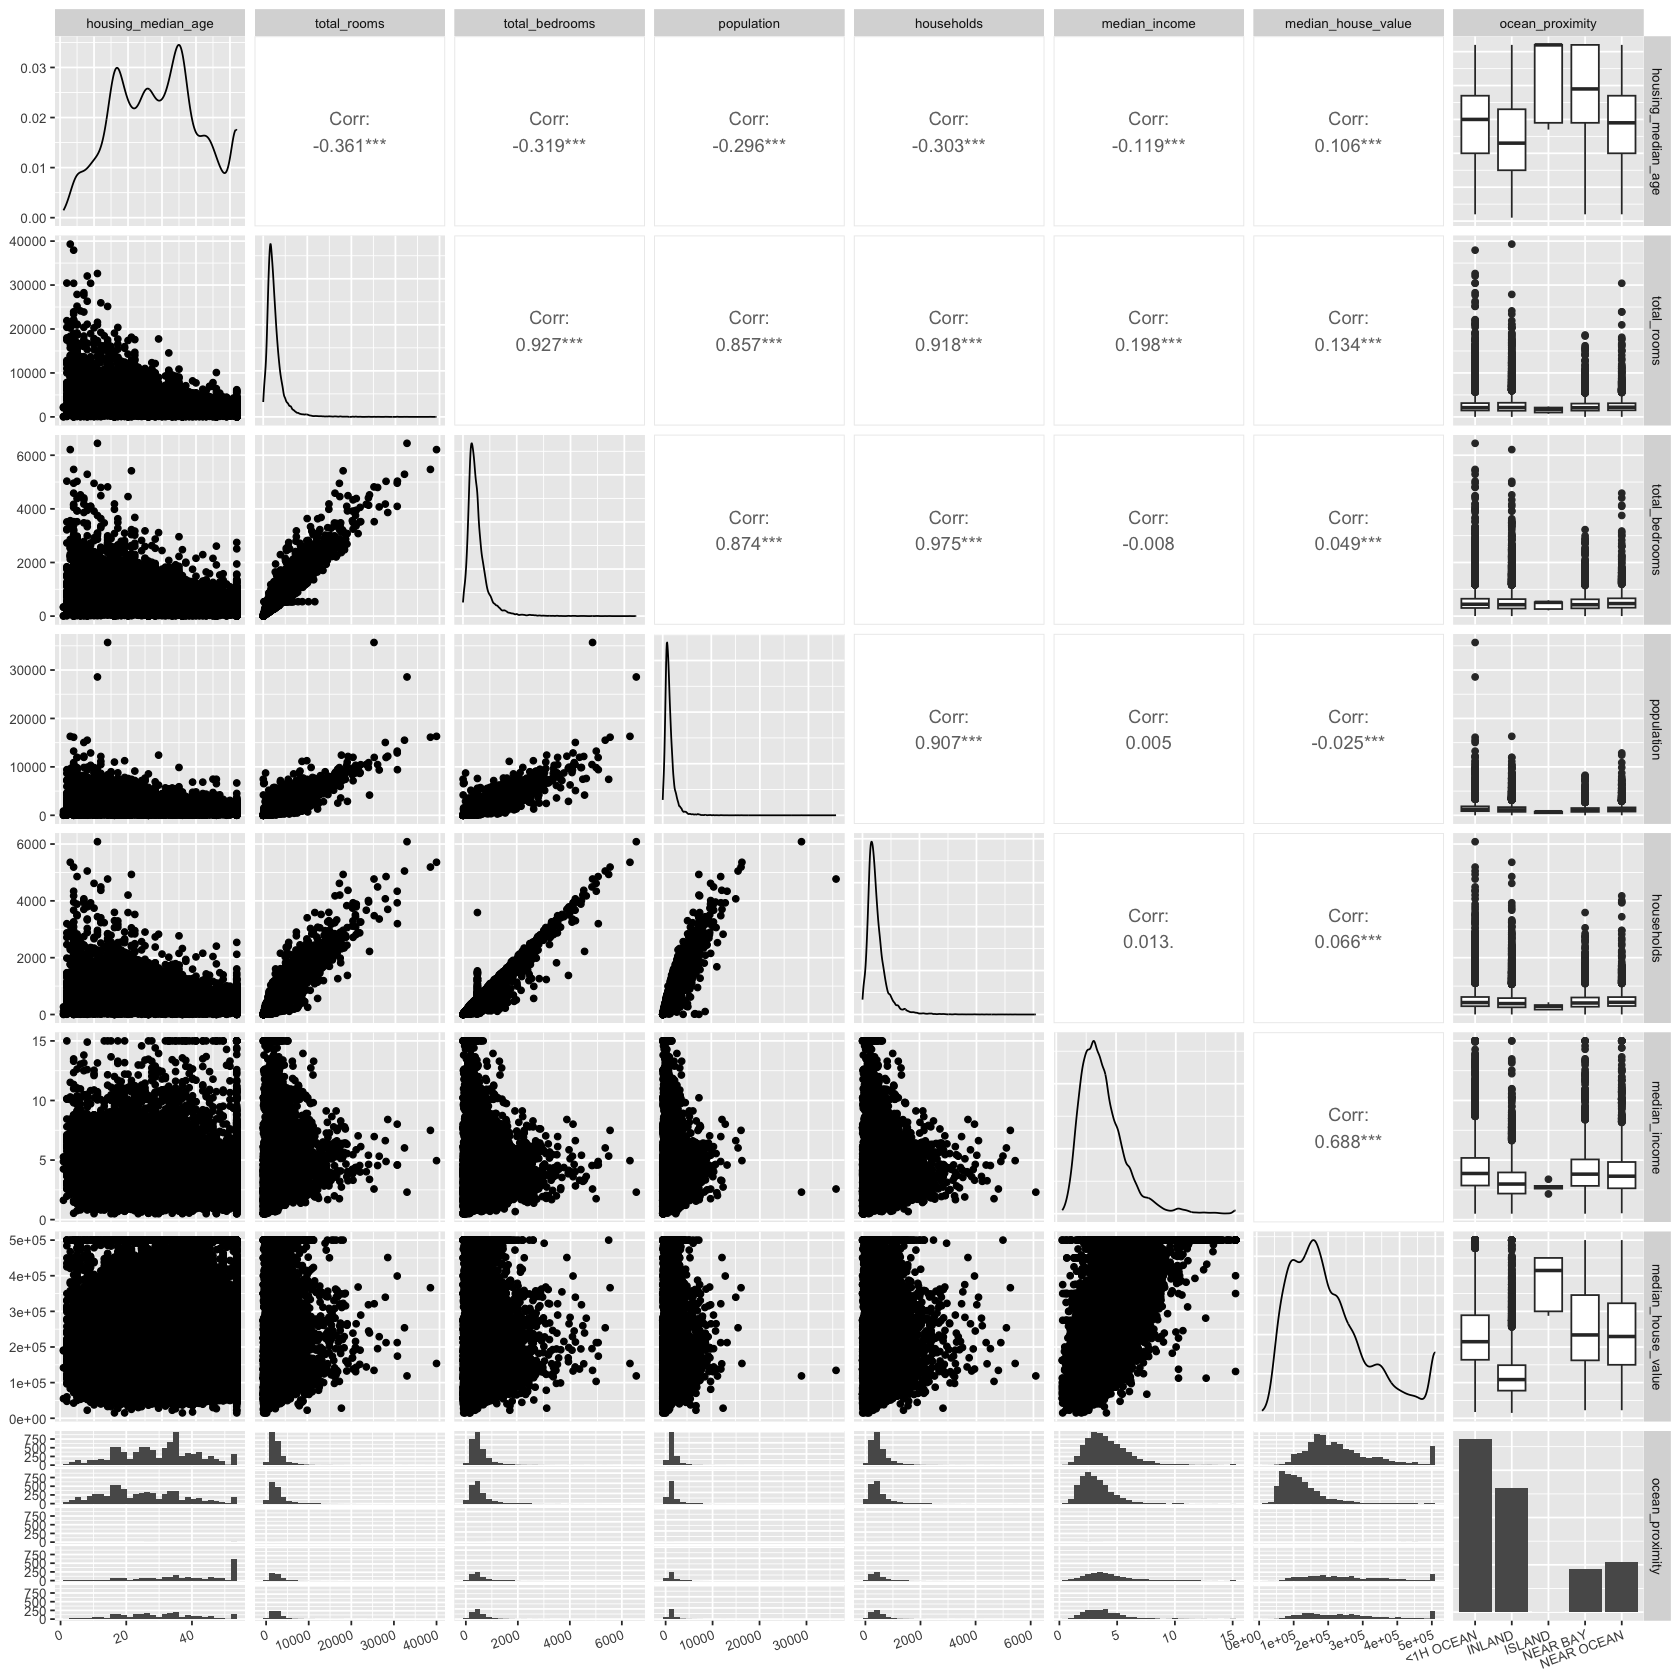

In [11]:
options(repr.plot.width = 14, repr.plot.height = 14)

pair_plots <- housing %>%
     ggpairs(progress = FALSE) +
theme(
     text = element_text(size = 10),
     plot.title = element_text(face = "bold"),
     axis.title = element_text(face = "bold"),
     axis.text.x = element_text(angle = 20, hjust = 1)
)
pair_plots

- Variable Distributions: Right-skewed distributions noted for 'total_bedrooms', 'total_rooms', 'population', and 'median_income'. 'Housing_median_age' showed multiple peaks, with a significant one beyond the median. 'Median_house_value' appeared bimodal with a distinct upper limit peak. 'Ocean_proximity' frequencies were uneven, with '<1H OCEAN' and 'INLAND' being more common.

- Histograms: These illustrated the numeric variable distributions across 'ocean_proximity' categories, essential for understanding category-specific trends.

- Boxplots: Displayed the interquartile range for numeric variables by 'ocean_proximity'. 'INLAND' had the lowest median house values, 'ISLAND' the highest, suggesting geographic influences on property valuation.

- Scatter Plots: Indicated strong correlations between variables such as 'total_rooms' and 'total_bedrooms', which could signify multicollinearity—a crucial consideration for regression analysis.

- Correlation Coefficients: Quantified the relationships seen in scatter plots, confirming strong positive correlations and informing us of multicollinearity that must be accounted for to ensure robust modeling.

This comprehensive visual analysis will guide the refinement of our predictive models by highlighting influential variables and potential data intricacies.

## Reference

Shi, Dequn, et al. “The effects of Park and sea landscape on property value in a tourist city.” Frontiers in Environmental Science, vol. 10, 2022, https://doi.org/10.3389/fenvs.2022.967094. 

Toussaint-Comeau, Maude, and Jin Man Lee. “Determinants of Housing Values and Variations in Home Prices Across Neighborhoods in Cook County.” Determinants of Housing Values and Variations in Home Prices across Neighborhoods in Cook County - Federal Reserve Bank of Chicago, 2018, www.chicagofed.org/publications/profitwise-news-and-views/2018/determinants-of-housing-values-and-variations-in-home-prices-across-neighborhoods-in-cook-county.